In [ ]:
import sys
import pickle
sys.path.append("..")

import torch
from torch.optim import AdamW
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration

from transformers import get_linear_schedule_with_warmup

from scripts.global_vars import (
    DEVICE, 
    BATCH_SIZE, 
    MODEL_NAME,
    USE_SAVE_CHECKPOINT,
    DELEXICALIZATION_RESPONSE,
    MAX_LENGTH_ENCODER_RESPONSE, 
    MAX_LENGTH_DECODER_RESPONSE
)

from scripts.pytorch.training import train_model
from scripts.pytorch.inference import inference_model
from scripts.utils import find_zero_percentage, plot_model_performance
from scripts.preprocessing.response import ResponseDataset, get_evaluation_score

___
### **STAGE 1. Dataset Loading and Preprocessing**
___

In [2]:
dataset = pickle.load(open("../../data/dataset.pkl", "rb"))

train_data = dataset['train']
val_data = dataset['validation']

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(
    legacy=True,
    pretrained_model_name_or_path=MODEL_NAME
)

train_response_dataset = ResponseDataset(
    data=dataset['train'],
    tokenizer=tokenizer,
    max_output_len=MAX_LENGTH_DECODER_RESPONSE,
    max_input_len=MAX_LENGTH_ENCODER_RESPONSE,
    delex=DELEXICALIZATION_RESPONSE
)

valid_response_dataset = ResponseDataset(
    data=dataset['validation'],
    tokenizer=tokenizer,
    max_output_len=MAX_LENGTH_DECODER_RESPONSE,
    max_input_len=MAX_LENGTH_ENCODER_RESPONSE,
    delex=DELEXICALIZATION_RESPONSE
)

train_loader_response = DataLoader(train_response_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_response = DataLoader(valid_response_dataset, batch_size=BATCH_SIZE)

batch = next(iter(train_loader_response))
print("\nRESPONSE IDs shape:", batch['encoder_input_ids'].shape)
print("Response IDs shape:", batch['decoder_input_ids'].shape)

Processing dialogues: 100%|██████████| 1000/1000 [00:00<00:00, 2303.03it/s]


RESPONSE IDs shape: torch.Size([256, 64])
Response IDs shape: torch.Size([256, 32])


In [4]:
train_encoder_zero = find_zero_percentage(train_loader_response, "encoder_input_ids", MAX_LENGTH_ENCODER_RESPONSE)
train_decoder_zero = find_zero_percentage(train_loader_response, "decoder_input_ids", MAX_LENGTH_DECODER_RESPONSE)
valid_encoder_zero = find_zero_percentage(valid_loader_response, "encoder_input_ids", MAX_LENGTH_ENCODER_RESPONSE)
valid_decoder_zero = find_zero_percentage(valid_loader_response, "decoder_input_ids", MAX_LENGTH_DECODER_RESPONSE)

In [5]:
print(
    "Train Encoder Zero Percentage:", train_encoder_zero * 100,
    "\nTrain Decoder Zero Percentage:", train_decoder_zero * 100,
    "\nValid Encoder Zero Percentage:", valid_encoder_zero * 100,
    "\nValid Decoder Zero Percentage:", valid_decoder_zero * 100
)

Train Encoder Zero Percentage: 24.295009672641754 
Train Decoder Zero Percentage: 35.385385155677795 
Valid Encoder Zero Percentage: 23.39279055595398 
Valid Decoder Zero Percentage: 34.25803482532501


___
### **STAGE 2. Model Training**
___

In [6]:
num_epochs = 5
num_training_steps = len(train_loader_response) * num_epochs
num_warmup_steps = num_training_steps // 10

response_model = T5ForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME
).to(DEVICE)

optimizer = AdamW(
    response_model.parameters(),
    lr=5e-3,
    eps=1e-8
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [7]:
if not USE_SAVE_CHECKPOINT:
    response_model = train_model(
        response_model,
        optimizer,
        scheduler,
        train_loader_response,
        valid_loader_response,
        num_epochs=num_epochs,
        device=DEVICE,
        save="../../models/multixoz_response_model.pth"
    )

else:
    response_model.load_state_dict(torch.load("../../models/multixoz_response_model.pth", weights_only=True, map_location=torch.device(DEVICE)))

___
### **STAGE 3. Model Evaluation**
___

In [8]:
if not USE_SAVE_CHECKPOINT:    
    generated_outputs_train = inference_model(
        response_model, 
        tokenizer, 
        train_response_dataset.actions, 
        MAX_LENGTH_ENCODER_RESPONSE, 
        MAX_LENGTH_DECODER_RESPONSE, 
        DEVICE,
        batch_size=1024,
        save="../../data/generated_outputs_train_response.pkl"
    )

    generated_outputs_valid = inference_model(
        response_model, 
        tokenizer, 
        valid_response_dataset.actions, 
        MAX_LENGTH_ENCODER_RESPONSE, 
        MAX_LENGTH_DECODER_RESPONSE, 
        DEVICE,
        batch_size=1024,
        save="../../data/generated_outputs_valid_response.pkl"
    )

else:
    generated_outputs_train = pickle.load(open("../../data/generated_outputs_train_response.pkl", "rb"))
    generated_outputs_valid = pickle.load(open("../../data/generated_outputs_valid_response.pkl", "rb"))

In [9]:
if not USE_SAVE_CHECKPOINT:
    train_evaluation = get_evaluation_score(
        generated_outputs_train, 
        train_response_dataset.responses,
        save="../../data/train_evaluation_response.pkl" 
    )
    valid_evaluation = get_evaluation_score(
        generated_outputs_valid, 
        valid_response_dataset.responses,
        save="../../data/valid_evaluation_response.pkl"
    )

else:
    train_evaluation = pickle.load(open("../../data/train_evaluation_response.pkl", "rb"))
    valid_evaluation = pickle.load(open("../../data/valid_evaluation_response.pkl", "rb"))

In [10]:
print("BLEU Score Train:", train_evaluation["bleu_score"])
print("BERT F1 Score Train:", train_evaluation["bert_f1_score"])
print("BLEU Score Valid:", valid_evaluation["bleu_score"])
print("BERT F1 Score Valid:", valid_evaluation["bert_f1_score"])

BLEU Score Train: 0.4088749241123804
BERT F1 Score Train: 0.5329248309135437
BLEU Score Valid: 0.40128789579821517
BERT F1 Score Valid: 0.5254555344581604


In [11]:
index = 1
inputs = valid_response_dataset.actions[index]

generated_output = inference_model(
    response_model,
    tokenizer,
    inputs,
    MAX_LENGTH_ENCODER_RESPONSE,
    MAX_LENGTH_DECODER_RESPONSE,
    DEVICE
)

print("\nUser Action:", inputs)
print("Generated Response:", generated_output)
print("True Response:", valid_response_dataset.responses[index])

Inference: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it]


User Action: [USER]: I need the address, postcode and the price range. [ACTION]: Restaurant-Recommend(address=Regent Street City Centre, name=Charlie Chan, postcode=cb21db, pricerange=cheap) | general-reqmore(none=none)
Generated Response: Charlie Chan is a great restaurant in the cheap price range. The address is Regent Street City Centre, postcode cb21db.
True Response: Ok how about Charlie Chan, located at Regent Street City Centre. Postcode is cb21db with a cheap price. Can I help you further today?


___
### **STAGE 4. Result Visualization**
___

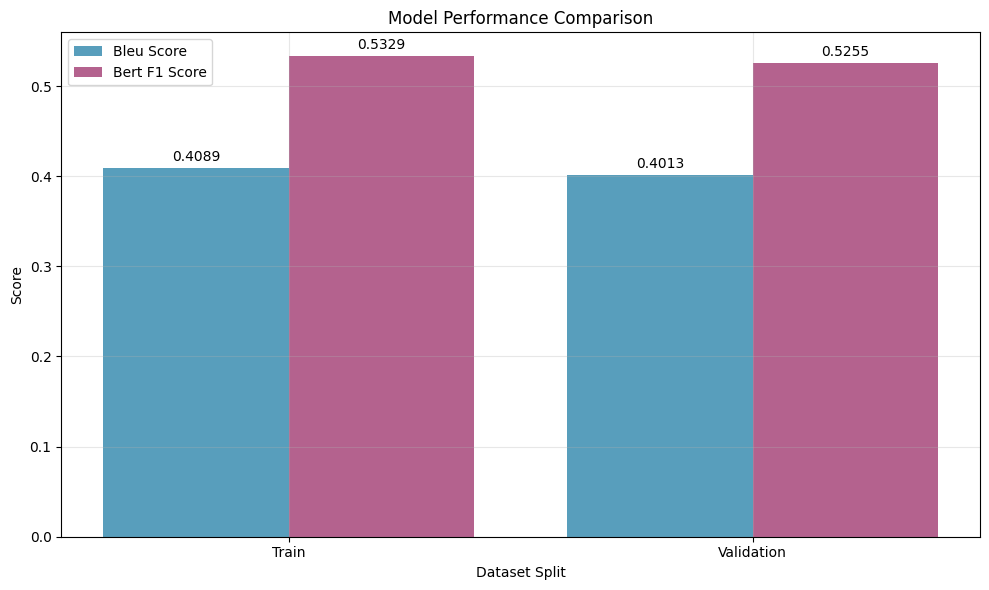

In [13]:
plot_model_performance(train_evaluation, valid_evaluation, save="../../performance/reponse_model_performance.png")